In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx

import numpy as np
import time

from history import History
from optimisers import train_step, resample_rad, PlateauLM

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson2D
problem = Poisson2D()

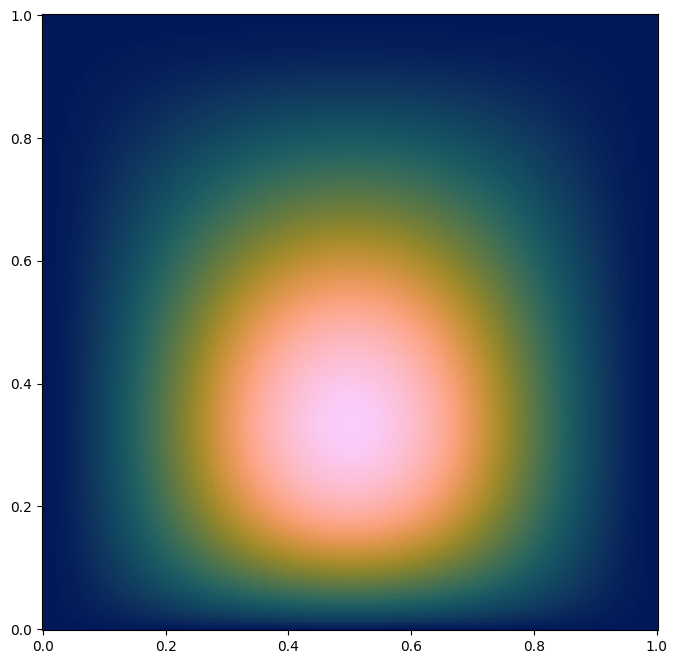

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, ny=256)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

In [4]:
key = jax.random.PRNGKey(42)

layer_sizes = [2, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
model = eqx.combine(params, static) 

# --- Collocation points ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 2.0
n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)
collocation_points = resample_rad(
    model,
    candidate_points,
    n_collocation_points,
    problem,
    rad_k,
    rad_c,
    sample_key
)

optimiser = PlateauLM(
    init_lambda=1e3,
    increase_factor=1.05,
    max_increase=5.0,
    plateau_factor=1.05,
)
opt_state = optimiser.init(params)

history = History()


<function matplotlib.pyplot.show(close=None, block=None)>

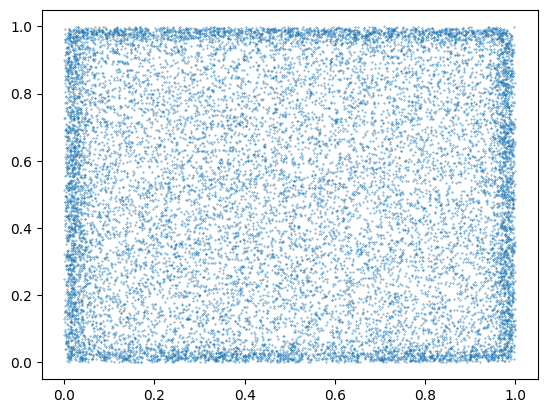

In [5]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [6]:
epoch = 0
total_train_step_time = 0

In [7]:
for _ in range(500):

    # Resample
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        model = eqx.combine(params, static) 
        
        sample_key, subkey = jax.random.split(sample_key, 2)
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )

    # Train
    start_train_step_time = time.monotonic()
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)
        
    # Print and record
    model = eqx.combine(params, static)
    u_pred = model.predict(X, T)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)
            
    metrics["rell2error"] = rel_l2_error
    metrics["time"] = total_train_step_time
        
    history.record(metrics)

    if epoch % (resample_every_n_epochs // 2) == 0:
        print(f"\n")
        print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}")
        print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")



Epoch 0, Loss: 4.209e+04
4.010e+00 20.523


Epoch 25, Loss: 1.138e-02
9.588e-01 45.844


Epoch 50, Loss: 1.769e-02
8.582e-01 66.845


Epoch 75, Loss: 9.928e-03
3.786e-01 87.491


Epoch 100, Loss: 5.679e-03
1.254e-01 107.289


Epoch 125, Loss: 8.425e-04
3.614e-02 127.465


Epoch 150, Loss: 7.867e-04
1.443e-02 147.281


Epoch 175, Loss: 5.793e-04
4.011e-02 167.554


Epoch 200, Loss: 5.076e-04
4.874e-02 188.208


Epoch 225, Loss: 4.275e-04
5.230e-02 208.944


Epoch 250, Loss: 4.188e-04
5.616e-02 230.534


Epoch 275, Loss: 3.567e-04
5.846e-02 250.484


Epoch 300, Loss: 3.692e-04
5.782e-02 270.037


Epoch 325, Loss: 2.960e-04
6.447e-02 289.269


Epoch 350, Loss: 2.970e-04
6.364e-02 309.690


Epoch 375, Loss: 2.667e-04
6.401e-02 330.068


Epoch 400, Loss: 2.705e-04
5.938e-02 351.284


Epoch 425, Loss: 2.538e-04
5.874e-02 370.532


Epoch 450, Loss: 2.726e-04
6.088e-02 390.515


Epoch 475, Loss: 2.646e-04
6.103e-02 408.984
Training complete.


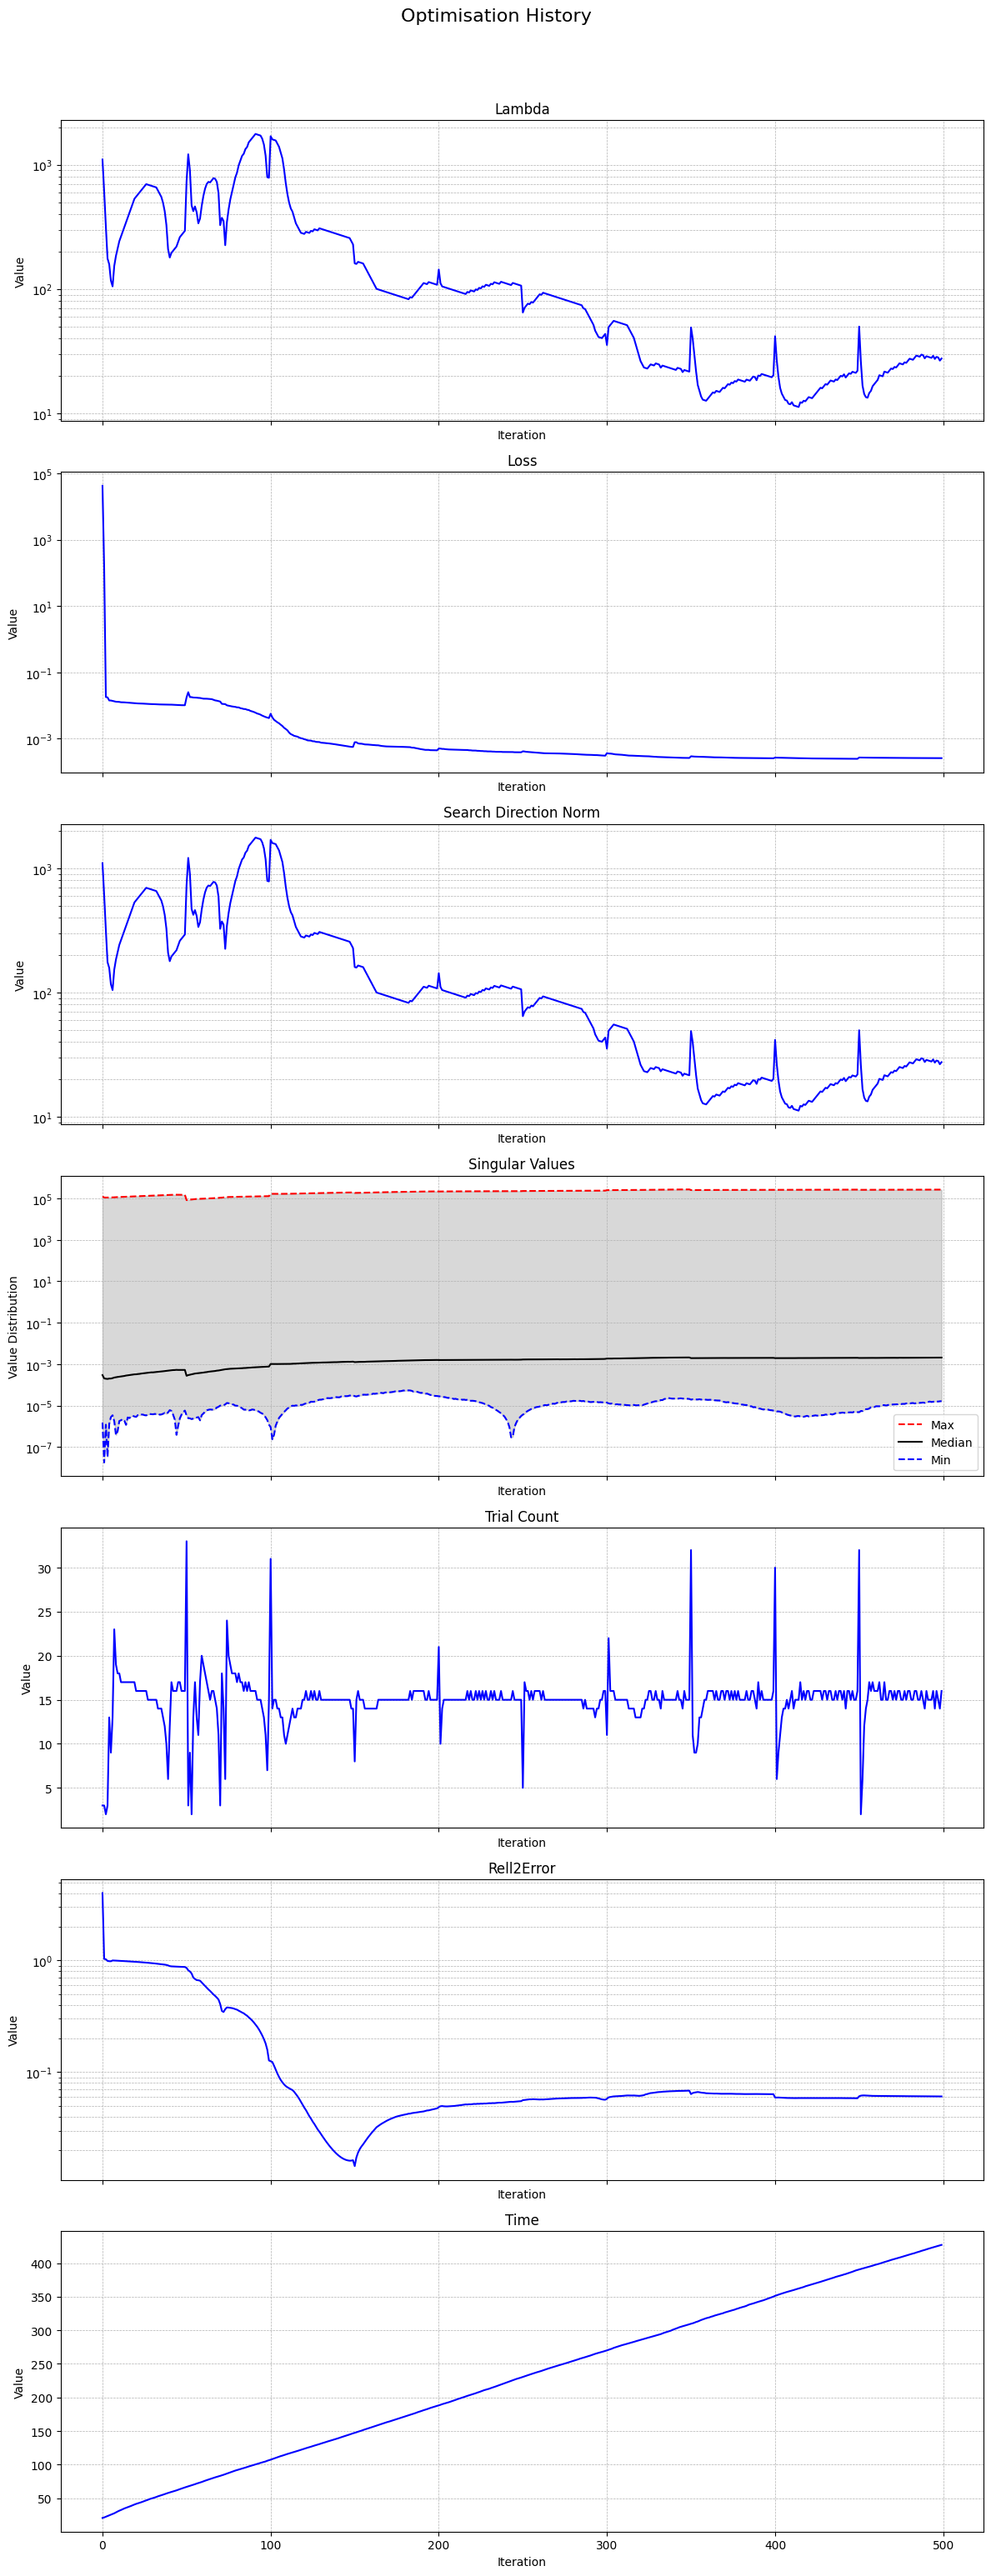

In [8]:
history.plot()

Relative L2 Error: 6.069e-02


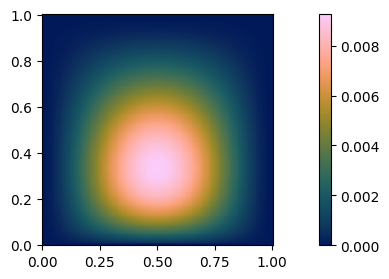

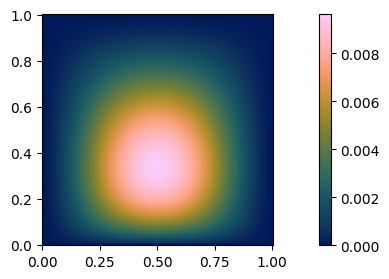

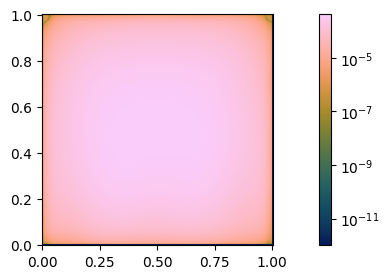

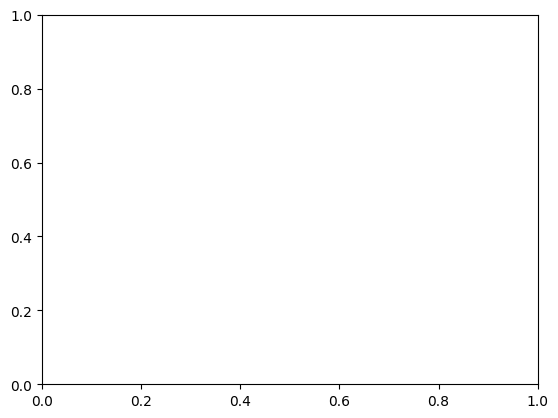

In [9]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, T, u_solution, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

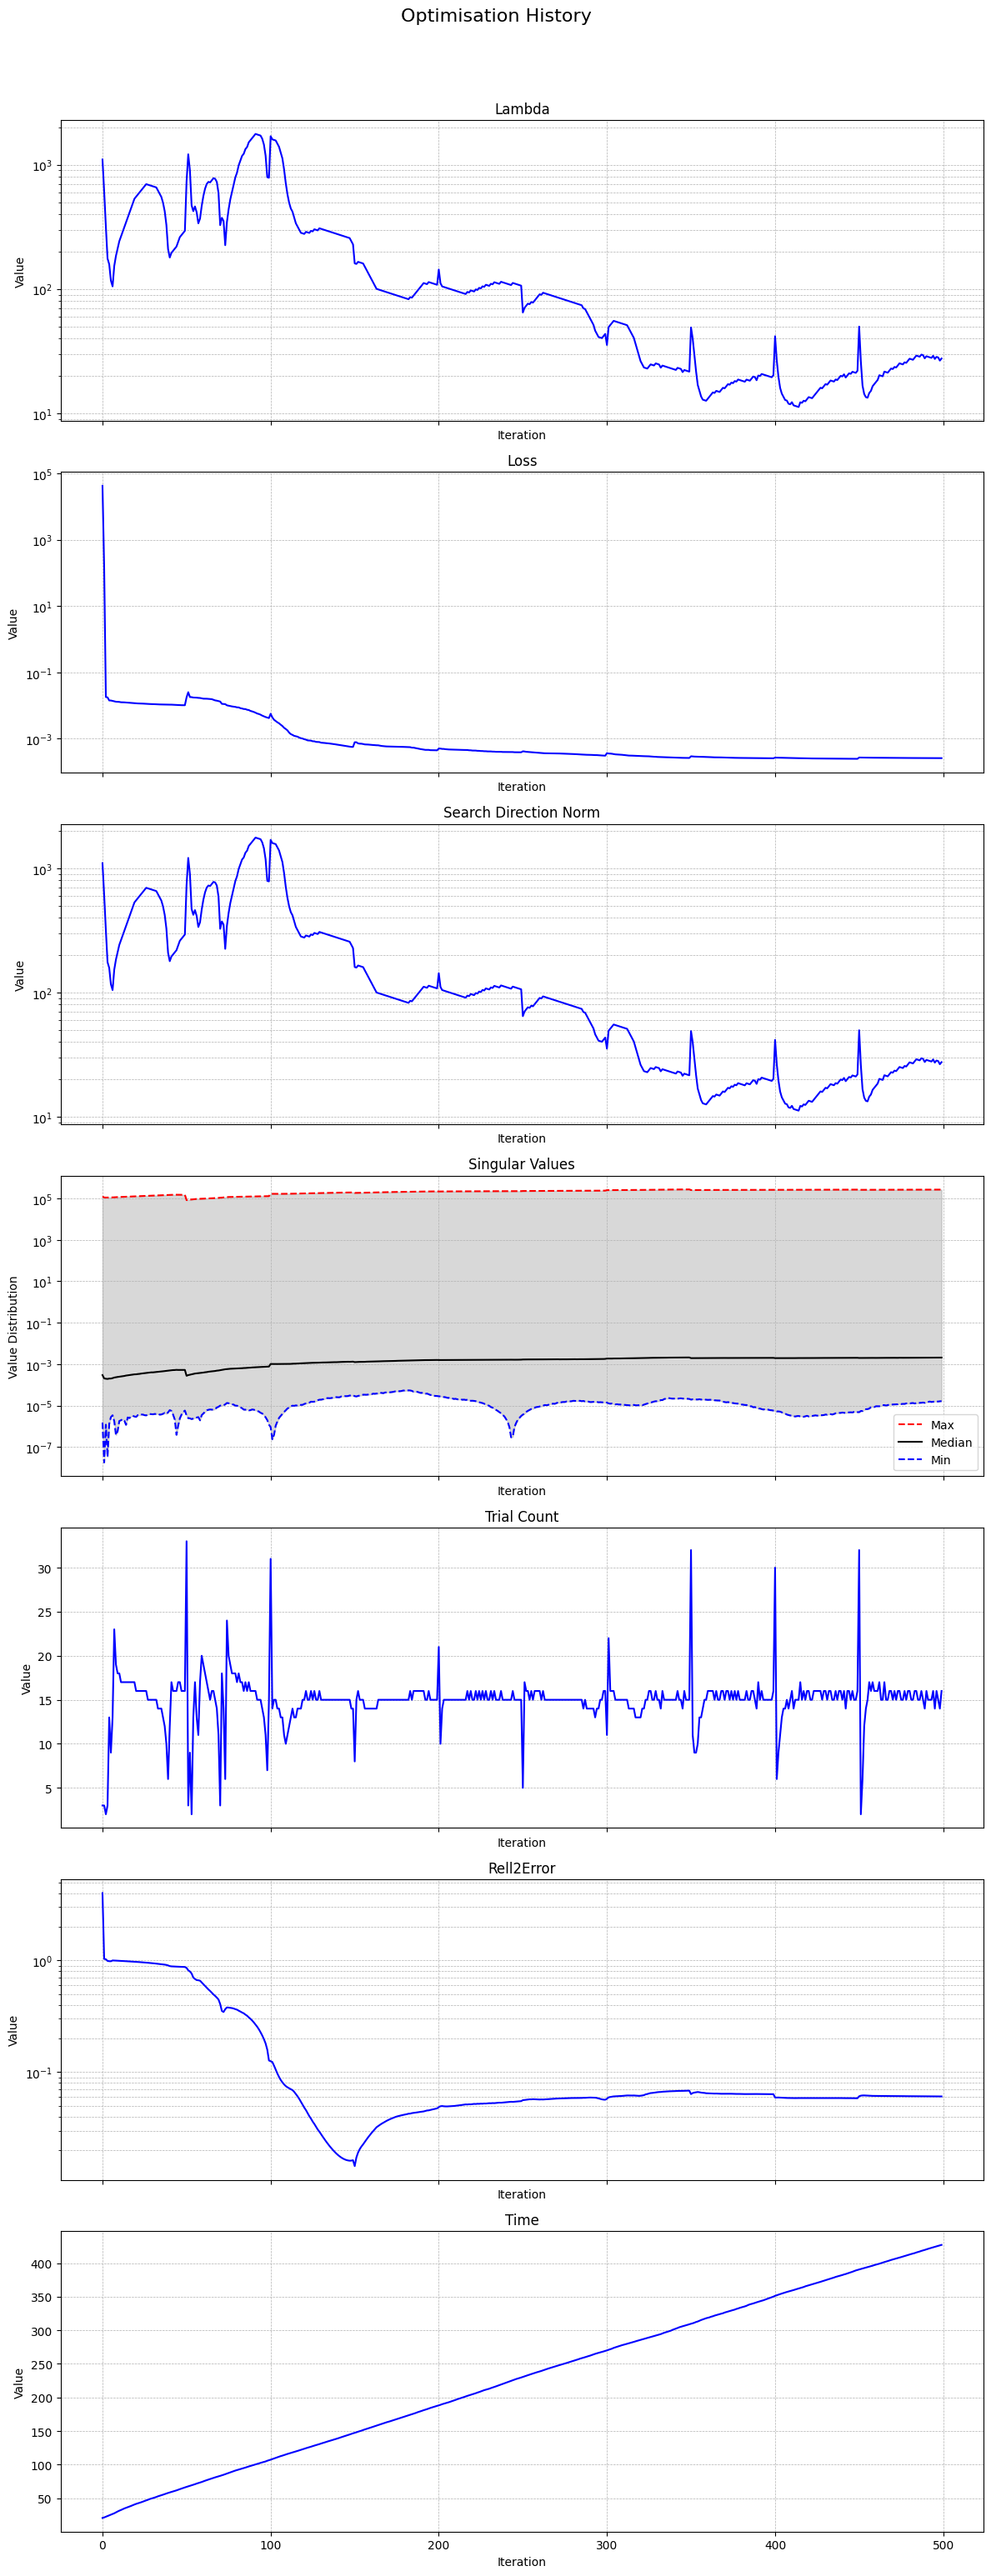

In [10]:
history.plot()

In [11]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [12]:
burgerslm_l2err = history.history["rell2error"][:400]
burgerslm_loss = history.history["loss"][:400]
burgerslm_lambda = history.history["lambda"][:400]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:400]
burgerslm_svs = history.history["singular_values"][:400]
burgerslm_time = history.history["time"][:400]

np.save('burgerslm_time.npy', burgerslm_time)
np.save('burgerslm_l2err.npy', burgerslm_l2err)
np.save('burgerslm_loss.npy', burgerslm_loss)
np.save('burgerslm_lambda.npy', burgerslm_lambda)
np.save('burgerslm_searchdirnorm.npy', burgerslm_searchdirnorm)
np.save('burgerslm_svs.npy', burgerslm_svs)
np.save('burgerslm_u_pred.npy', u_pred)
np.save('burgerslm_u_solution.npy', u_solution)
np.save('burgerslm_X.npy', X)
np.save('burgerslm_T.npy', T)


In [13]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

0.014430065732774599
0.06353914485262516


<function matplotlib.pyplot.show(close=None, block=None)>

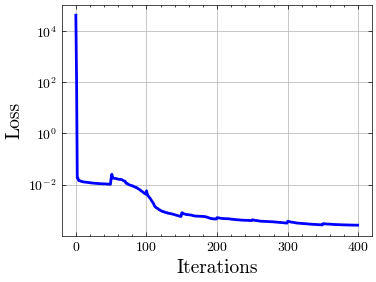

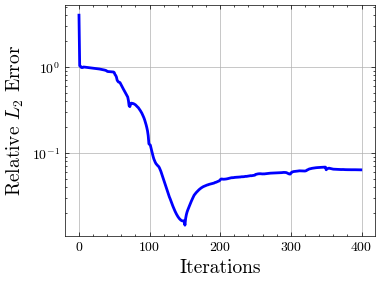

In [14]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

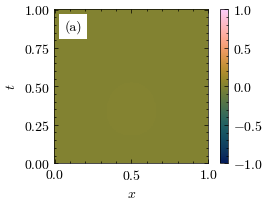

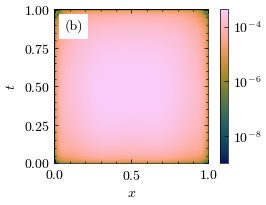

In [15]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()